In [1]:
# We load the competition data

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import warnings
warnings.filterwarnings("ignore")

/kaggle/input/playground-series-s5e8/sample_submission.csv
/kaggle/input/playground-series-s5e8/train.csv
/kaggle/input/playground-series-s5e8/test.csv


# Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from ydata_profiling import ProfileReport

# Binary Classification with a Bank Dataset

### Playground Series - Season 5, Episode 8

### Your Goal: 

Your goal is to predict whether a client will subscribe to a bank term deposit.

### Evaluation:

Submissions are evaluated using ROC AUC between the predicted value and the observed target.

### Submission File:

For each id in the test set, you must predict the probability of the binary target y. The file should contain a header and have the following format:

    id,y
    750000,0.5
    750001,0.5
    750002,0.5
    etc.

### Timeline:

- Start Date - August 1, 2025
- Entry Deadline - Same as the Final Submission Deadline
- Team Merger Deadline - Same as the Final Submission Deadline
- Final Submission Deadline - August 31, 2025

All deadlines are at 11:59 PM UTC on the corresponding day unless otherwise noted. The competition organizers reserve the right to update the contest timeline if they deem it necessary.

# Initial analysis

We'll start by loading the training data, and taking a first look to see what variables we have for this problem, as well as the number of samples.

In [3]:
# We load the data

bank_train = pd.read_csv("/kaggle/input/playground-series-s5e8/train.csv", index_col="id")

In [4]:
bank_train.shape

(750000, 17)

In [5]:
bank_train.head()

age          job  marital  education default  balance housing loan  \
id                                                                       
0    42   technician  married  secondary      no        7      no   no   
1    38  blue-collar  married  secondary      no      514      no   no   
2    36  blue-collar  married  secondary      no      602     yes   no   
3    27      student   single  secondary      no       34     yes   no   
4    26   technician  married  secondary      no      889     yes   no   

     contact  day month  duration  campaign  pdays  previous poutcome  y  
id                                                                        
0   cellular   25   aug       117         3     -1         0  unknown  0  
1    unknown   18   jun       185         1     -1         0  unknown  0  
2    unknown   14   may       111         2     -1         0  unknown  0  
3    unknown   28   may        10         2     -1         0  unknown  0  
4   cellular    3   feb       902         1     -1         0  unknown  1

In [6]:
bank_train.describe()

age        balance            day       duration  \
count  750000.000000  750000.000000  750000.000000  750000.000000   
mean       40.926395    1204.067397      16.117209     256.229144   
std        10.098829    2836.096759       8.250832     272.555662   
min        18.000000   -8019.000000       1.000000       1.000000   
25%        33.000000       0.000000       9.000000      91.000000   
50%        39.000000     634.000000      17.000000     133.000000   
75%        48.000000    1390.000000      21.000000     361.000000   
max        95.000000   99717.000000      31.000000    4918.000000   

            campaign          pdays       previous              y  
count  750000.000000  750000.000000  750000.000000  750000.000000  
mean        2.577008      22.412733       0.298545       0.120651  
std         2.718514      77.319998       1.335926       0.325721  
min         1.000000      -1.000000       0.000000       0.000000  
25%         1.000000      -1.000000       0.000000       0.000000  
50%         2.000000      -1.000000       0.000000       0.000000  
75%         3.000000      -1.000000       0.000000       0.000000  
max        63.000000     871.000000     200.000000       1.000000

In [7]:
bank_train.describe(exclude=np.number)

job  marital  education default housing    loan   contact  \
count       750000   750000     750000  750000  750000  750000    750000   
unique          12        3          4       2       2       2         3   
top     management  married  secondary      no     yes      no  cellular   
freq        175541   480759     401683  737151  411288  645023    486655   

         month poutcome  
count   750000   750000  
unique      12        4  
top        may  unknown  
freq    228411   672450

In [8]:
bank_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 750000 entries, 0 to 749999
Data columns (total 17 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   age        750000 non-null  int64 
 1   job        750000 non-null  object
 2   marital    750000 non-null  object
 3   education  750000 non-null  object
 4   default    750000 non-null  object
 5   balance    750000 non-null  int64 
 6   housing    750000 non-null  object
 7   loan       750000 non-null  object
 8   contact    750000 non-null  object
 9   day        750000 non-null  int64 
 10  month      750000 non-null  object
 11  duration   750000 non-null  int64 
 12  campaign   750000 non-null  int64 
 13  pdays      750000 non-null  int64 
 14  previous   750000 non-null  int64 
 15  poutcome   750000 non-null  object
 16  y          750000 non-null  int64 
dtypes: int64(8), object(9)
memory usage: 103.0+ MB


We encountered a binary classification problem, with our target variable 'y', in addition to 16 features, 7 of which are numeric and 9 categorical. Regarding the number of samples, we had a total of 750,000 for training. For the numeric variables, we can observe quite wide and diverse ranges of values, which makes their management in terms of possible outliers and scaling something to take into account. On the other hand, the categorical variables, with the exception of two of them that contain a high number of unique values, range from two to four values, with three of them binary. We will proceed to exploratory data analysis, where we can explore the dataset in more depth.

# EDA

For this notebook, we'll combine two methods: one based on autoEDA and another based on a more individual approach for each feature. The initial analysis included 17 variables with different ranges and data types. Therefore, a broader and more in-depth analysis will help us later in the work. We'll initially use autoEDA to gain an overview of the data and then complement the information obtained, expanding the analysis of each variable with new graphs and statistical analyses to expand on what we learned from the tool.

For the autoEDA method, we'll use YData Profiling, which automates and standardizes the generation of detailed reports, complete with statistics and visualizations.

https://docs.profiling.ydata.ai/latest/

In [9]:
# We pass the data to the profiler

profile_bank_data = ProfileReport(bank_train, title="Bank Data Profiling Report")

# Get the full profile

profile_bank_data

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████| 17/17 [00:13<00:00,  1.25it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Once we have the general information from the tool, we will proceed to analyze each variable individually to not only expand the analysis but also corroborate what we observed. We will attempt to perform this crucial step for an initial investigation of the data, with the goal of identifying patterns, outliers, and imbalances, and to test different hypothesis.

In [10]:
# Establishing the seaborn aesthetic

sns.set_style("darkgrid")

# We establish the color palette

palette = sns.set_palette("Greens_r")

In [11]:
# Function for categorical variables

def plot_categories(data, figsize, sizes, labels, colors, explode, title):

    print(
    "\nNumber of null values: ", data.isnull().sum(),
    "\nUnique values: ", data.nunique(),
    "\nDistribution of values: \n", data.value_counts(), "\n\n"
    )

    fig, axes = plt.subplots(1, 2, figsize=figsize)
    
    axes[0].pie(
        sizes, 
        labels=labels, 
        autopct='%1.1f%%', 
        startangle=90, 
        colors=colors,
        wedgeprops={"edgecolor" : "k"},
        explode=explode,
        textprops={'fontsize': 12}
    )
    axes[0].set_ylabel("")
    
    sns.histplot(
        data=data,
        color="green",
        edgecolor="k",
        ax=axes[1]
    )
    axes[1].set_xlabel("")
    axes[1].set_ylabel("")
    
    # Add labels with the exact value above each bar
    
    for container in axes[1].containers:
        axes[1].bar_label(container, fontsize=12)
    
    fig.suptitle(title, fontsize=18)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

In [12]:
# Function for numeric variables

def plot_numeric(data, column, figsize, title):

    print(
    "\nNumber of null values: ", data[column].isnull().sum(),
    "\nUnique values: ", data[column].nunique(),
    "\nVariable range:", data[column].min(), "to", data[column].max(), "\n\n"
    )

    # We graph the distribution
    
    fig, axes = plt.subplots(ncols=2, figsize=figsize)
    
    sns.stripplot(
        data=data, 
        x=column,
        jitter=True,
        palette=palette,
        ax=axes[0]
    )
    sns.boxenplot(
        data=data, 
        x=column,
        palette=palette,
        ax=axes[1]
    )
    plt.suptitle(t=title)
    plt.tight_layout()
    plt.show()

### y (Target variable)

Since term deposits allow banks to hold a deposit for a specific period, they can invest in higher-yielding financial products to earn profits. Furthermore, banks are more likely to persuade their customers to purchase other products, such as funds or insurance, to further increase their revenues. For this reason, there is fierce competition among banks to convince their customers to take out term deposits. Because of these marketing campaigns, banks invest large amounts of money in contacting potential customers. They want to identify existing customers most likely to take out a term deposit and focus their marketing efforts on them. We apply machine learning algorithms to build a predictive model from the dataset and provide the necessary suggestion to the marketing campaign team. The goal is to predict whether a customer will take out a term deposit or not. A "yes" for the bank if a term deposit is taken out; a "no" for any other outcome.


Number of null values:  0 
Unique values:  2 
Distribution of values: 
 y
No     659512
Yes     90488
Name: count, dtype: int64 




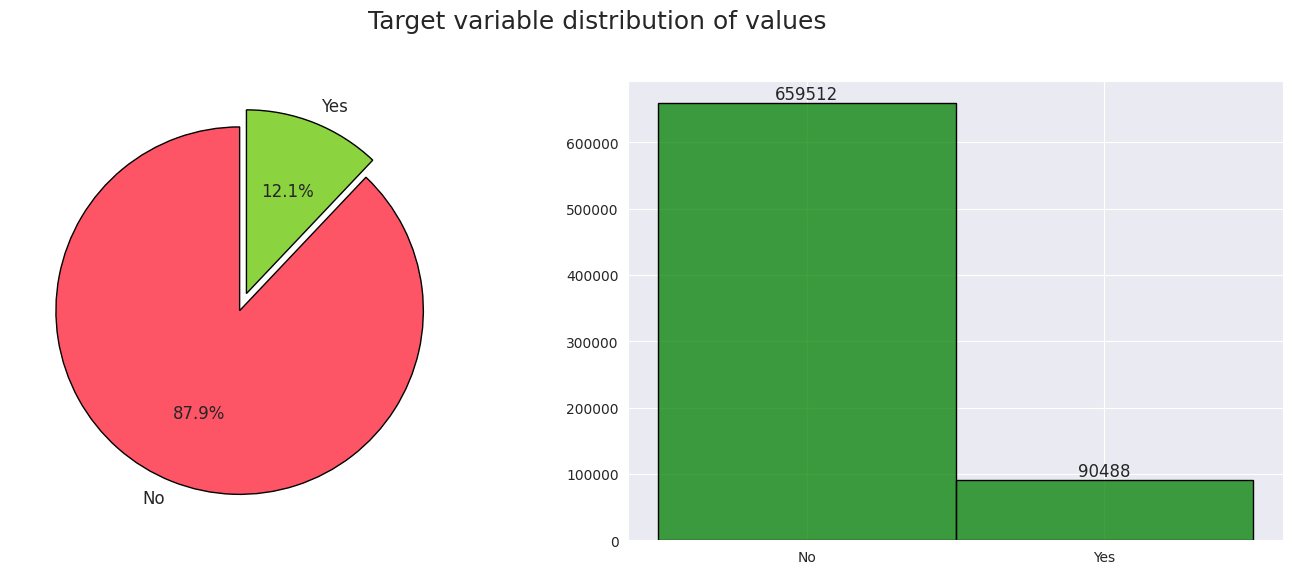

In [13]:
# We create a variable for the analysis

subscribe_to = bank_train["y"].replace([0, 1], ["No", "Yes"]).astype("category")

# We print and graph the distribution

counts_t = subscribe_to.value_counts()
labels_t = counts_t.index
sizes_t = counts_t.values
title_t = "Target variable distribution of values"

plot_categories(subscribe_to, (14, 6), sizes_t, labels_t, ["#fd5565","#8bd33f"], (0.0, 0.1), title_t)

The variable has two distinct values, representing whether or not the potential client subscribed to the term deposit. We did not detect any missing or erroneous values, but we did observe a class imbalance. It is observed that the majority of clients did not subscribe, with 87.9% of securities in class '0' and 12.1% in class '1' accepting the subscription offer. This clear class imbalance is a very important factor when determining how to proceed throughout the project.

### Age

This variable, as its name suggests, represents the age of the bank's customers. It's common to collect general customer information to assess age groups and target campaigns and products to each specific group or individual. It is a quantitative variable that can be continuous or discrete depending on how it is measured. In most cases, it is considered a ratio variable, as it has a natural zero and allows for meaningful mathematical operations. However, when grouped into categories, it can be considered an ordinal variable.


Number of null values:  0 
Unique values:  78 
Variable range: 18 to 95 




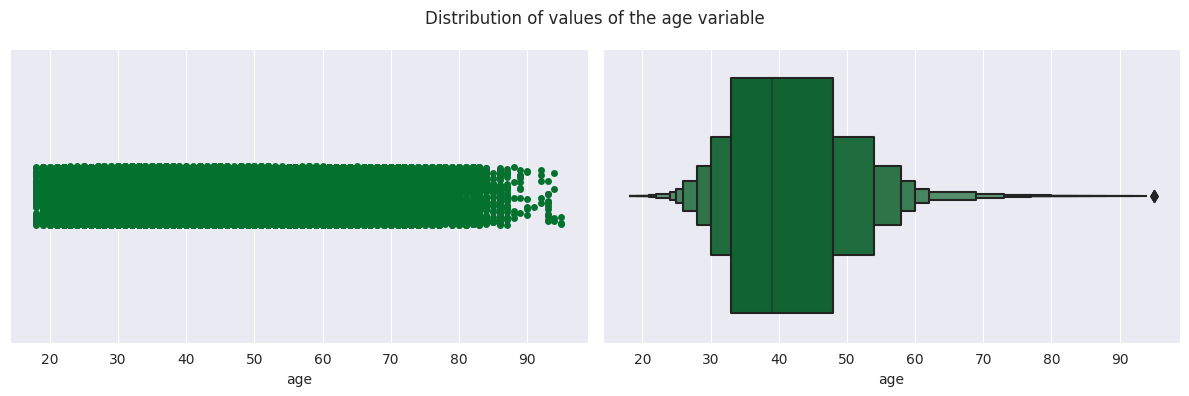

In [14]:
# We print and graph the distribution

plot_numeric(bank_train, "age", (12, 4), "Distribution of values of the age variable")

The variable does not present any missing or erroneous values. We found 78 unique values, with an average customer age of 41 years and a median of 39 years. The range of values or ages spans from 18 to 95 years. Analyzing the 5th or 95th percentiles, the range covers 27 to 58 years, with potential outliers at the minimum and maximum values. We observed a right-skewed distribution, so the highest values are more widely distributed. We could separate the variable into bins, in addition to handling outliers.

### Job

This variable groups the jobs of the bank's clients into different categories. Job variables can be both personal (skills, knowledge, experience) and professional (education, specific experience in a field, technical skills). Understanding these variables is crucial for companies who use them to define profiles and evaluate potential services or campaigns depending on the client's field of work.


Number of null values:  0 
Unique values:  12 
Distribution of values: 
 job
management       175541
blue-collar      170498
technician       138107
admin.            81492
services          64209
retired           35185
self-employed     19020
entrepreneur      17718
unemployed        17634
housemaid         15912
student           11767
unknown            2917
Name: count, dtype: int64 




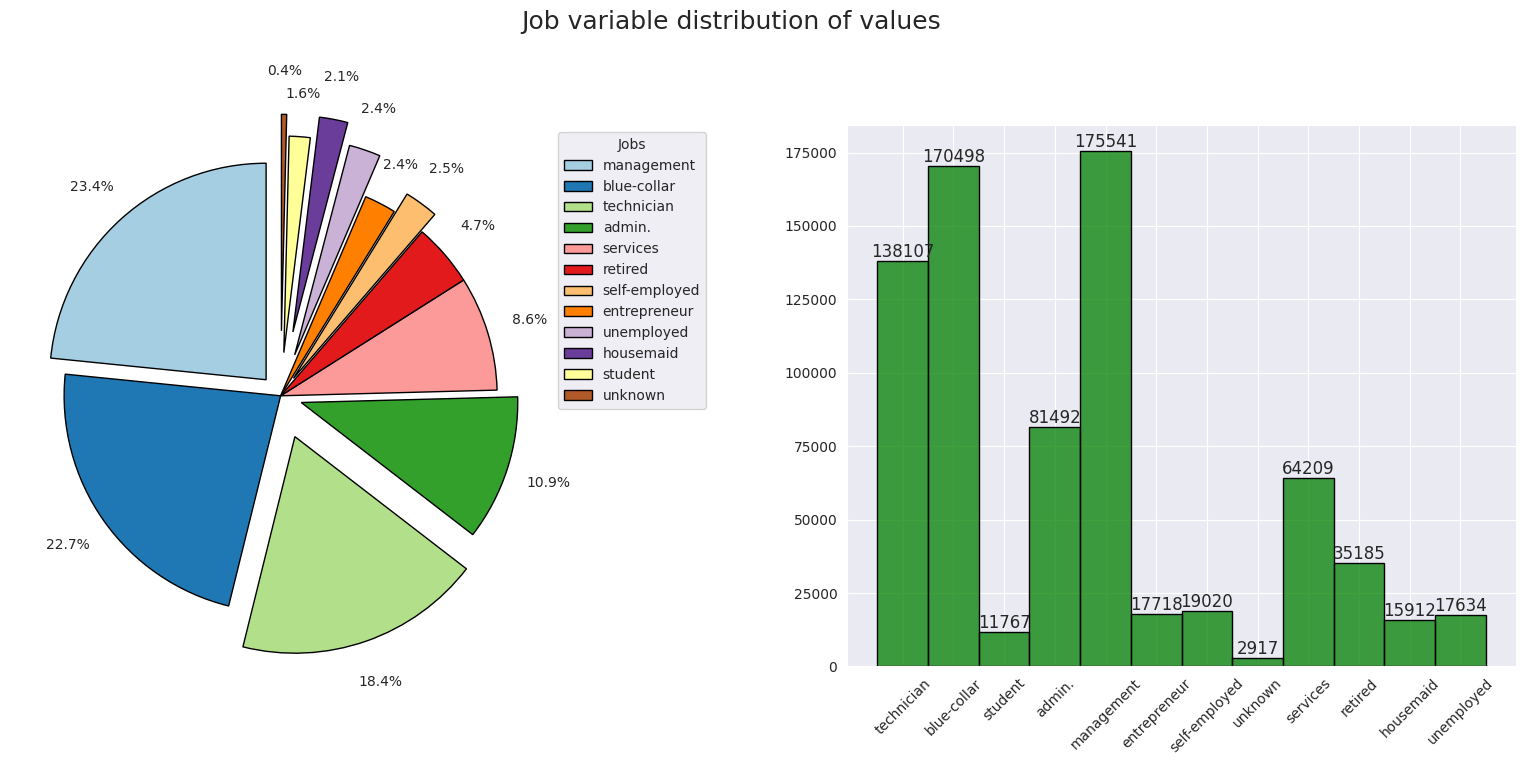

In [15]:
# We print the general information of the variable

print(
    "\nNumber of null values: ", bank_train["job"].isnull().sum(),
    "\nUnique values: ", bank_train["job"].nunique(),
    "\nDistribution of values: \n", bank_train["job"].value_counts(), "\n\n"
    )

# We analyze the distribution

counts_j = bank_train["job"].value_counts()
labels_j = counts_j.index
sizes_j = counts_j.values

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

explode = (0.1, 0.0, 0.2, 0.1, 0.0, 0.0, 0.1, 0.0, 0.2, 0.3, 0.2, 0.3)

axes[0].pie(
    sizes_j,
    autopct='%1.1f%%',
    pctdistance=1.20,
    explode=explode,
    startangle=90,
    colors=sns.color_palette("Paired"),
    wedgeprops={"edgecolor" : "k"}
)
axes[0].set_ylabel("")
axes[0].legend(
    labels_j,
    title="Jobs",
    loc="upper left",
    bbox_to_anchor=(1, 0, 0.5, 1)
)
sns.histplot(
    data=bank_train["job"],
    color="green",
    edgecolor="k",
    ax=axes[1]
).tick_params(axis='x', labelrotation=45)
axes[1].set_xlabel("")
axes[1].set_ylabel("")

# Add labels with the exact value above each bar

for container in axes[1].containers:
    axes[1].bar_label(container, fontsize=12)

fig.suptitle("Job variable distribution of values", fontsize=18)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

We found a categorical variable with 12 unique values, representing the different professions that group the bank's customers. We see that one of the categories is "Unknown," meaning that some customers did not specify their profession or simply had missing values. The most common categories are managers, technicians, and blue-collar, which means the bank targets high-wage earners. Finding a way to handle the labels for this variable, taking into account the number of unique values, is an important consideration when preprocessing the data.

### Marital

This variable represents the clients marital status. The term "marital status" refers to a person's legal or social status with respect to their marital status. Common categories include single, married, divorced, widowed, and, in some cases, separated or in a common-law union. Marital status is a qualitative variable; it describes a category or quality of a client. For a more detailed explanation:

- Single: A person who has never been married.
- Married: A person who has been legally married.
- Divorced: A person whose marriage has been legally dissolved.
- Widowed: A person whose spouse has died.
- Separated: A married person who lives separately from their spouse but has not legally formalized the divorce.
- Common-law union: A person who lives with another person without being legally married, also called cohabitation.

Marital status can be relevant to various studies and analyses, as it can influence aspects such as household composition, family relationships, and economic situation—all information that is relevant to banks when targeting various campaigns or services.


Number of null values:  0 
Unique values:  3 
Distribution of values: 
 marital
married     480759
single      194834
divorced     74407
Name: count, dtype: int64 




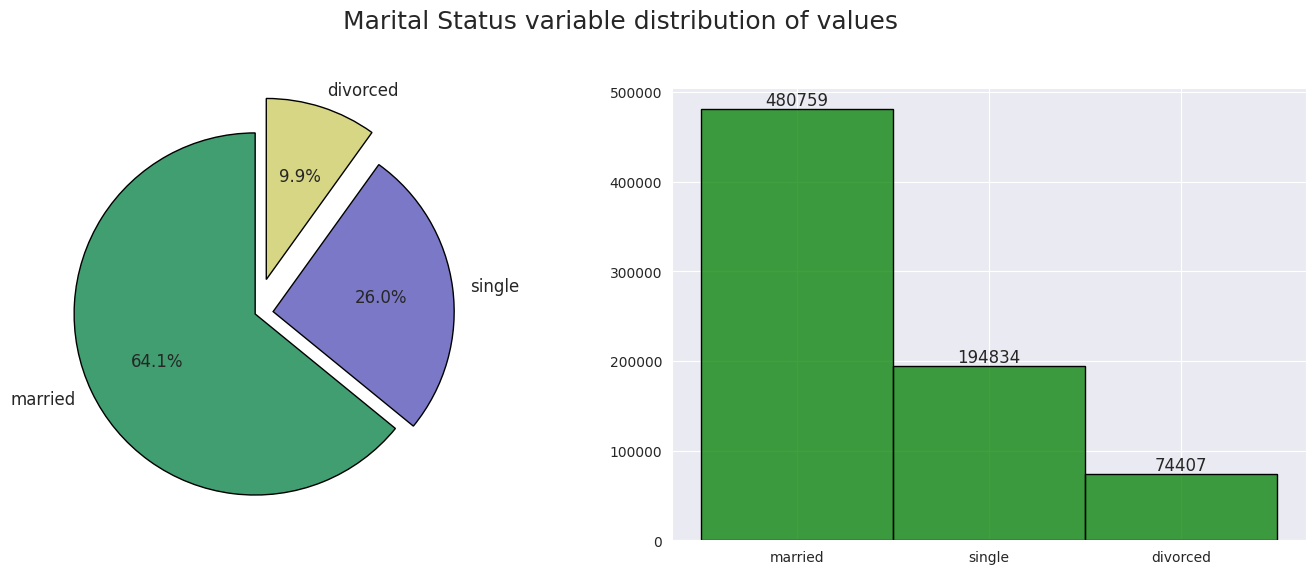

In [16]:
# We print and graph the distribution

counts_m = bank_train["marital"].value_counts()
labels_m = counts_m.index
sizes_m = counts_m.values
color_m = ["#409e70", "#7b79c7", "#d7d684"]
explode_m = (0.0, 0.1, 0.2)
title_m = "Marital Status variable distribution of values"

plot_categories(bank_train["marital"], (14, 6), sizes_m, labels_m, color_m, explode_m, title_m)

We found three values or categories for this variable: married, single, and divorced. The majority of clients were married, implying that the bank likely targets a clientele with a conventional household, or that it represents the most common condition. We did not find any erroneous or missing values, and it is possible to map this variable for preprocessing, taking the order by number of samples.

### Education

The variable "education" generally refers to the measure of an individual's educational attainment. This variable can be ordinal, as it represents different levels of education that have an inherent order (primary, secondary, university). It can also refer to the "level of education" variable, which is also ordinal, depending on the study site. Furthermore, the variable can include information on the type of education (general or vocational) and the quality of education. In analysis, the variable can be either independent or dependent. For example, in a study on the impact of education on job performance, education would be the independent variable, while job performance would be the dependent variable. In other cases, education could be a control variable to analyze the relationship between other variables.


Number of null values:  0 
Unique values:  4 
Distribution of values: 
 education
secondary    401683
tertiary     227508
primary       99510
unknown       21299
Name: count, dtype: int64 




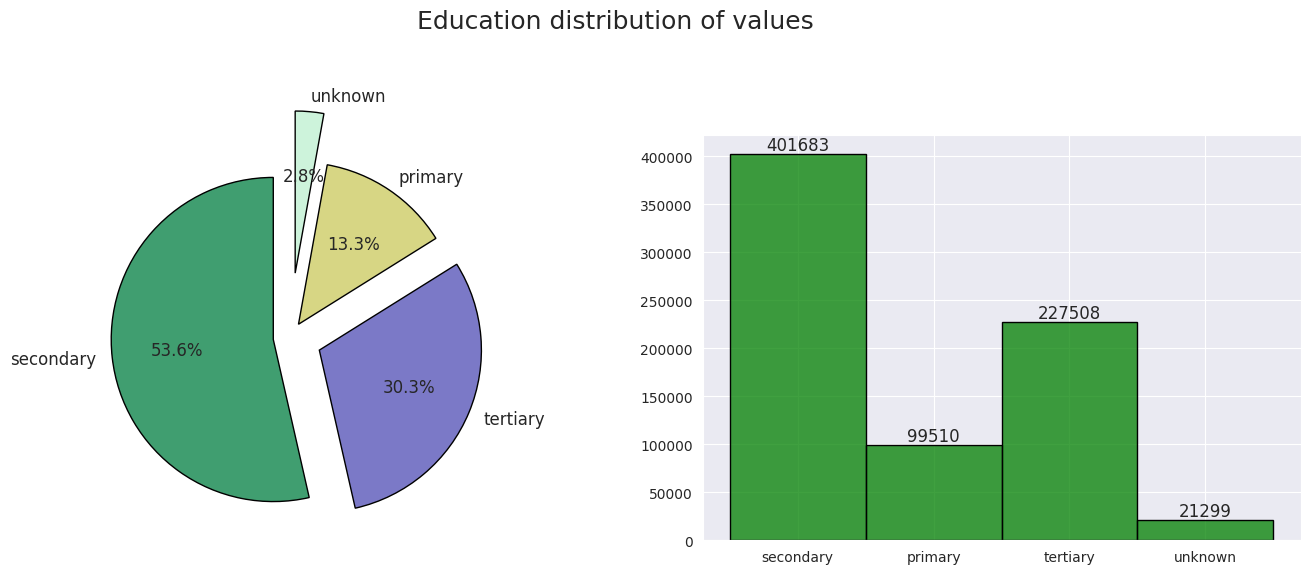

In [17]:
# We print and graph the distribution

counts_e = bank_train["education"].value_counts()
labels_e = counts_e.index
sizes_e = counts_e.values
color_e = ["#409e70", "#7b79c7", "#d7d684", "#cdf3db"]
explode_e = (0.1, 0.2, 0.1, 0.4)
title_e = "Education distribution of values"

plot_categories(bank_train["education"], (14, 6), sizes_e, labels_e, color_e, explode_e, title_e)

This variable has four unique values or categories representing the clients different educational levels, in addition to not presenting erroneous or null values. Again, we find the "unknown" category, representing a lack of education, information not provided by the client, or simply a missing value. We can observe that the majority of clients have completed high school, and 30.3% have tertiary education. This is logical considering that higher education is expected to lead to higher salaries. This variable could be mapped to a logical educational order.

### Default

This variable represents the default on a loan payment according to the terms agreed upon in the promissory note, whether the customer defaulted or not. A default is one or more missed payments on borrowed money. An example of a default would be a missed credit card payment or a monthly mortgage payment. Defaulted customers are those who fail to make the agreed-upon payment on a debt. The customer can be an individual, a company, a local or regional authority, or even an entire country. The debt can consist of secured or unsecured loans.


Number of null values:  0 
Unique values:  2 
Distribution of values: 
 default
no     737151
yes     12849
Name: count, dtype: int64 




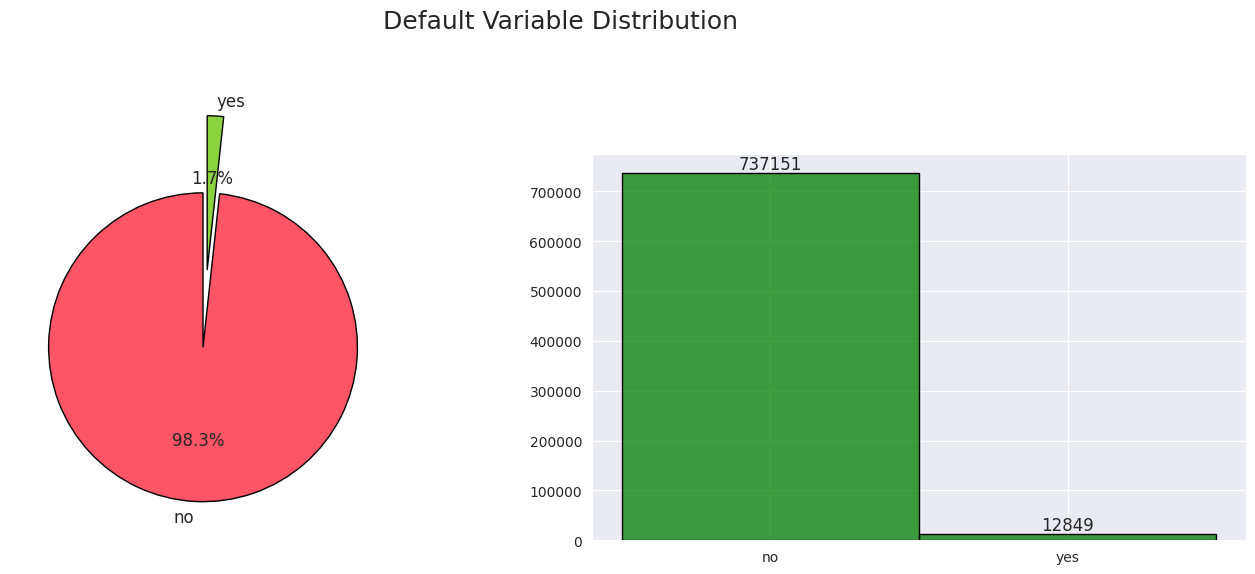

In [18]:
# We print and graph the distribution

counts_d = bank_train["default"].value_counts()
labels_d = counts_d.index
sizes_d = counts_d.values
title_d = "Default Variable Distribution"

plot_categories(bank_train["default"], (14, 6), sizes_d, labels_d, ["#fd5565","#8bd33f"], (0.0, 0.5), title_d)

The variable presents two unique values, "No" which represents almost all of the samples, and "Yes" which only represents 1.7% of the samples. This distribution is logical, since the data represent a bank's customers; it would be illogical to find a large number of defaulted individuals. Considering its distribution, we could discard this variable, since it would not be surprising if its significance were low, but we will analyze this later in the project.

### Balance

In accounting, a balance sheet variable refers to an account on the balance sheet (or statement of financial position) whose balance can be either positive (credit) or negative (debit), indicating whether the account acts as an asset or liability at a given time. These accounts reflect the financial situation of a company or client and are critical to understanding their economic health.


Number of null values:  0 
Unique values:  8217 
Variable range: -8019 to 99717 




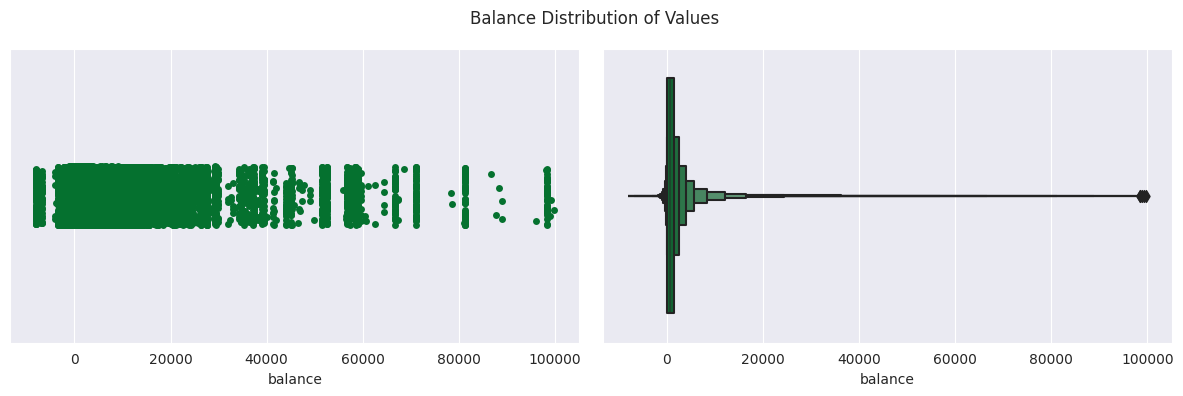

In [19]:
# We print and graph the distribution

plot_numeric(bank_train, "balance", (12, 4), "Balance Distribution of Values")

We are dealing with a continuous quantitative variable with a high cardinality, with values ranging from a negative -8019 to 99717. Looking at the distribution of values, we find a high presence of values at 0, in addition to a distribution skewed to the right, with the presence of a very pronounced tail. We are in the presence of a large number of outliers, finding the 5th percentile at -287, and the 95th percentile at 4493 respectively. The median is around 634, and the average, almost double, is around 1204. Handling or transforming this variable will be important for it to be useful.

### Housing

In the context of data analysis and statistics, a "housing variable" refers to any characteristic or attribute related to housing that can be measured or observed and that may vary between different housing units. These variables can be either numerical or categorical and are used to describe and analyze housing characteristics in a population or individual, as in this case.

Examples of housing variables:

- Housing type: House, apartment, flat, etc.
- Number of rooms: An integer indicating the number of rooms in the dwelling.
- Housing tenure: Owned, rented, etc.
- Household composition: Number of people living in the dwelling.
- Utilities available: Central heating, running water, electricity, etc.
- Property condition: New, renovated, old, etc.
- Housing location: Country, city, neighborhood, etc.

Housing variables allow us to study the distribution of the population across different housing types and analyze housing patterns. Market research to understand the demand for different types of housing and help make informed decisions in the real estate market, planning new construction and infrastructure development, or socioeconomic studies to analyze the relationship between housing type and socioeconomic status, as is of interest in the case of these data.


Number of null values:  0 
Unique values:  2 
Distribution of values: 
 housing
yes    411288
no     338712
Name: count, dtype: int64 




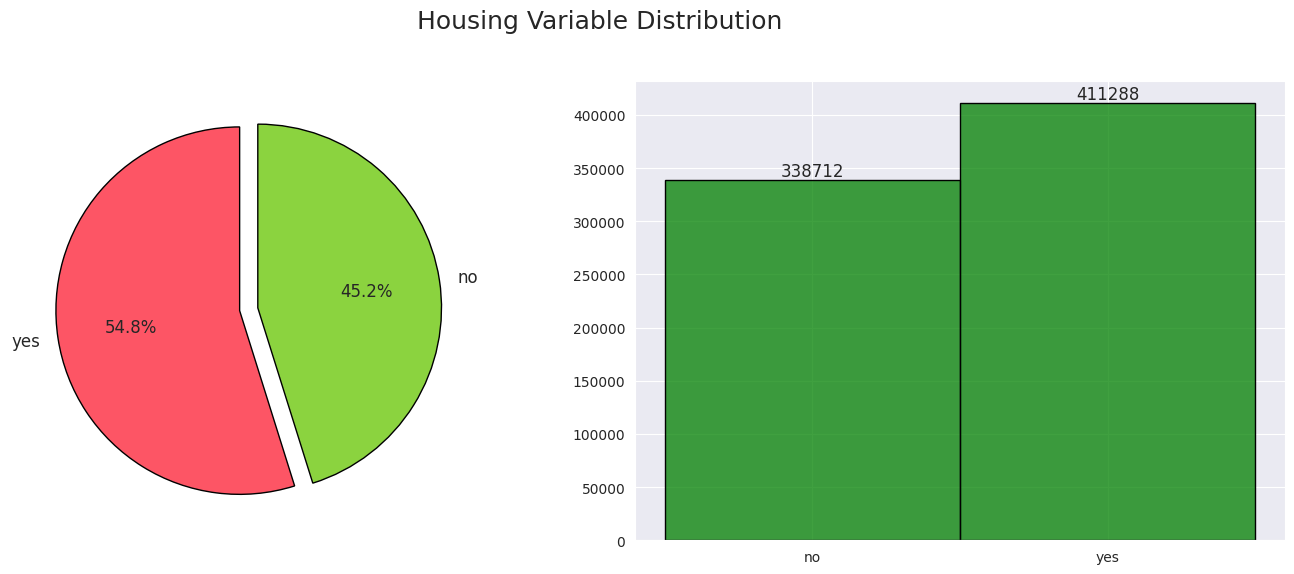

In [20]:
# We print and graph the distribution

counts_h = bank_train["housing"].value_counts()
labels_h = counts_h.index
sizes_h = counts_h.values
title_h = "Housing Variable Distribution"

plot_categories(bank_train["housing"], (14, 6), sizes_h, labels_h, ["#fd5565","#8bd33f"], (0.0, 0.1), title_h)

The variable contains two unique values, which in this case we can deduce represent whether the client is a homeowner or not. It could also be related to home loans, which would reverse the logic of its analysis. It doesn't contain much information or specific categories, which is more common in this type of variable. The distribution could be considered even, with 54.8% for homeowners or clients with loans, and 45.2% for clients who meet other characteristics. The variable does not present any null or erroneous values. A joint analysis with the loan variable could provide more information.

### Loan

Loan variables are very important for banking institutions, as well as for any financial institution, that wishes to analyze or evaluate their clients, whether to offer services or a campaign. Evaluating whether a client has loans is crucial for determining their solvency and managing credit risk for both the lender and the client. It allows for informed decisions regarding loan approval, establishing appropriate terms, and avoiding losses due to bad debts. It also helps protect the client's interests by preventing over-indebtedness. Evaluating a client's loan situation is an essential practice for any credit-granting institution, as it protects both its own interests and those of the client. It allows for more informed decisions, minimizes risks, and promotes financial inclusion responsibly.


Number of null values:  0 
Unique values:  2 
Distribution of values: 
 loan
no     645023
yes    104977
Name: count, dtype: int64 




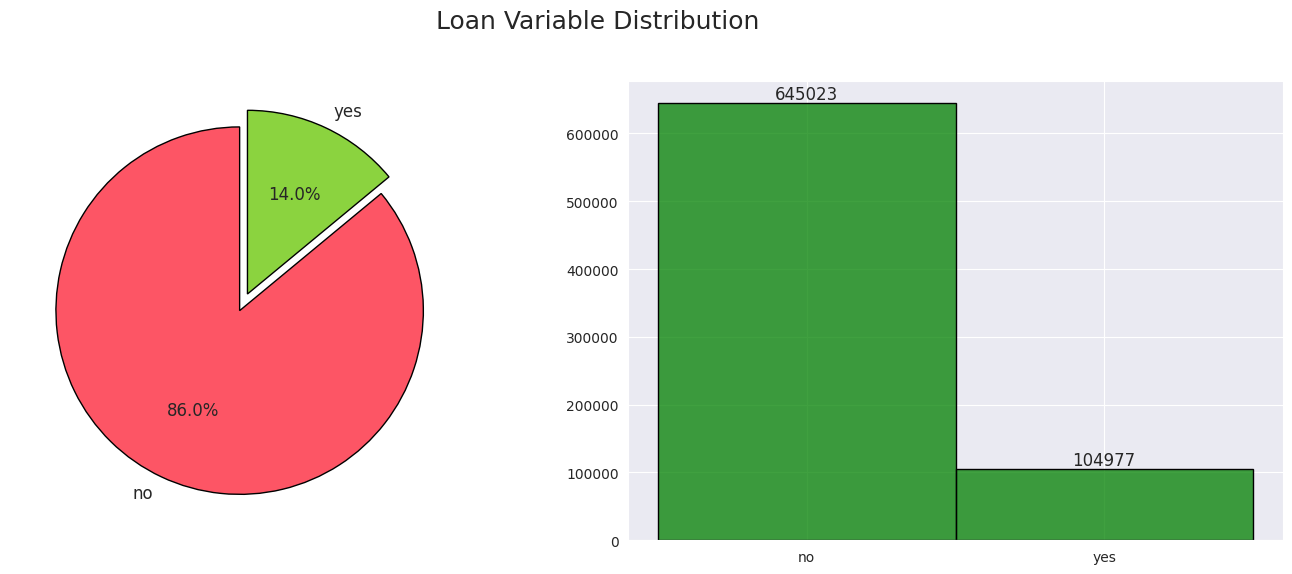

In [21]:
# We print and graph the distribution

counts_l = bank_train["loan"].value_counts()
labels_l = counts_l.index
sizes_l = counts_l.values
title_l = "Loan Variable Distribution"

plot_categories(bank_train["loan"], (14, 6), sizes_l, labels_l, ["#fd5565","#8bd33f"], (0.0, 0.1), title_l)

The variable does not present null or erroneous values. It contains two unique values, representing whether the person took out a loan or not. The values are mostly centered, with 86.0% labeled "No." This implies that the majority of the bank's customers do not have a loan, or at least not one with the bank. Furthermore, based on these results, we can establish that the variable housing is not related to housing loans.

### Contact

Contact information refers to the personal data that allows others to contact a person or business. This data typically includes name, phone number, email address, physical address, and, in some cases, social media profiles or professional websites. Essentially, it's information that facilitates communication and connection between individuals or between a person and an entity. It allows others to contact you for various purposes, such as inquiries or business dealings. Displaying complete and up-to-date contact information can build trust with a company or individual. In the context of businesses, it allows you to organize and manage customer or supplier information. Contact information is essential for communication, relationship building, and the effective management of both personal and professional interactions.


Number of null values:  0 
Unique values:  3 
Distribution of values: 
 contact
cellular     486655
unknown      231627
telephone     31718
Name: count, dtype: int64 




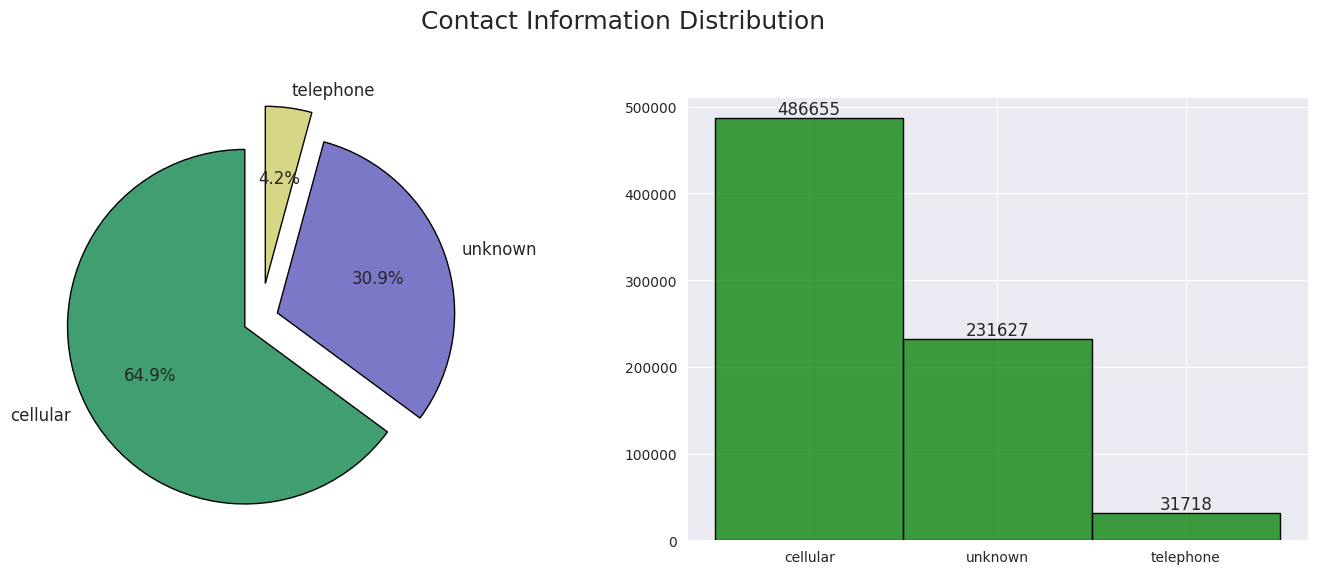

In [22]:
# We print and graph the distribution

counts_c = bank_train["contact"].value_counts()
labels_c = counts_c.index
sizes_c = counts_c.values
color_c = ["#409e70", "#7b79c7", "#d7d684"]
explode_c = (0.1, 0.1, 0.2)
title_c = "Contact Information Distribution"

plot_categories(bank_train["contact"], (14, 6), sizes_c, labels_c, color_c, explode_c, title_c)

The variable contains the bank's customer contacts. These are entirely communication-related, such as landline phone numbers, which account for 4.2% of the samples, and cell phone numbers, which, unsurprisingly, comprise the largest amount of data. Finally, we find a class for "unknown," which could mean a missing value or that the bank communicates with these customers through other means, such as email. Furthermore, the variable does not contain null or erroneous values.

### Day & Month

In the context of dates, the variables "day" and "month" refer to individual components of a date. The day is represented by the ordinal number within a month, while the month can be represented by the ordinal number from 1 to 12 or by its corresponding full representation; in some contexts, a shortened representation can also be used. Both variables, "day" and "month," are essential components for defining a complete date and are fundamental for the manipulation and analysis of date-related data. Their importance is broad when developing time series.


Number of null values Day:  0 
Unique values Day:  31 
Variable range Day: 1 to 31 


Number of null values Month:  0 
Unique values Month:  12 
Distribution of values: 
 month
may    228411
aug    128859
jul    110647
jun     93670
nov     66062
apr     41319
feb     37611
jan     18937
oct      9204
sep      7409
mar      5802
dec      2069
Name: count, dtype: int64 




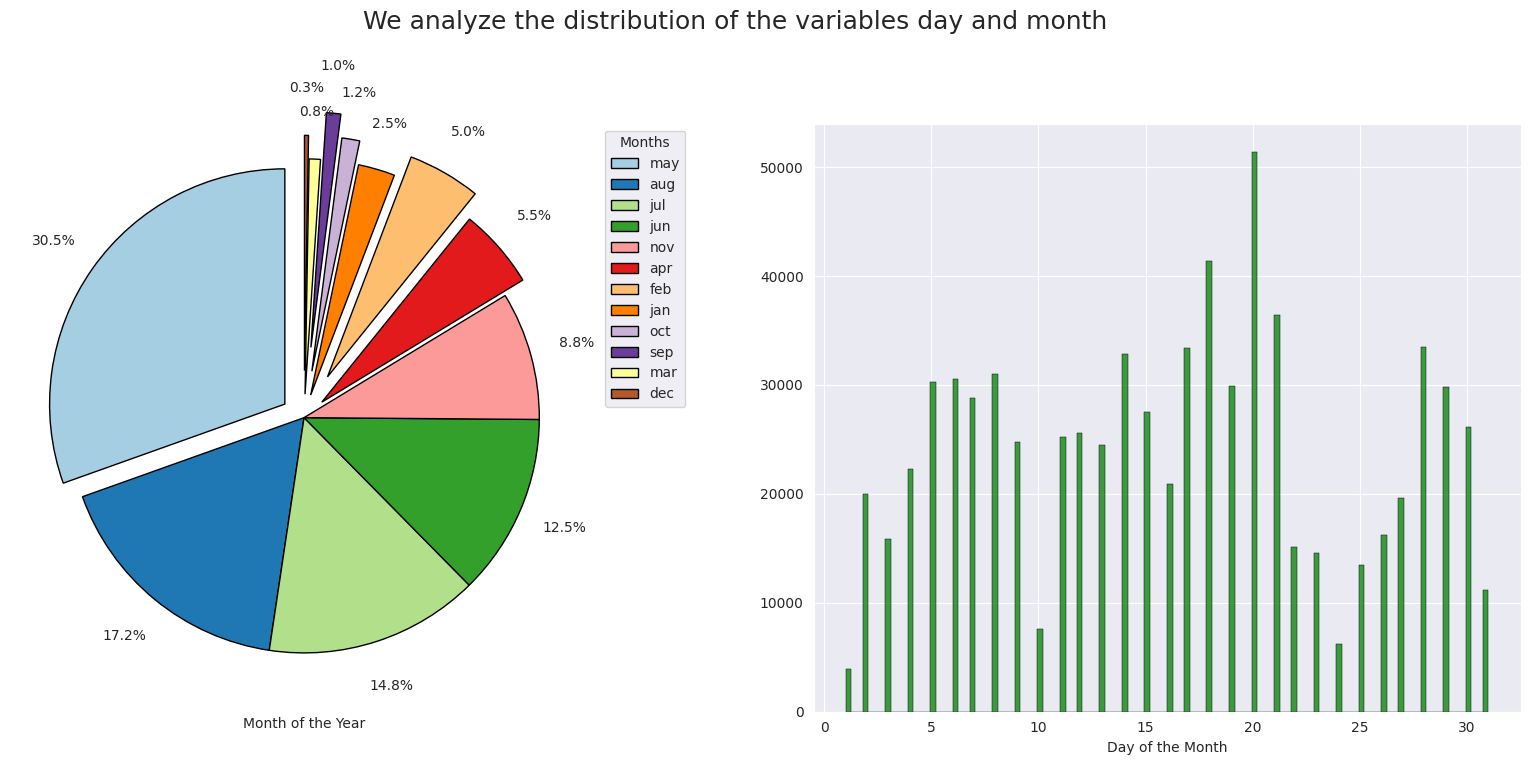

In [23]:
# We print the general information of the variable

print(
    "\nNumber of null values Day: ", bank_train["day"].isnull().sum(),
    "\nUnique values Day: ", bank_train["day"].nunique(),
    "\nVariable range Day:", bank_train["day"].min(), "to", bank_train["day"].max(), "\n\n"
    "\nNumber of null values Month: ", bank_train["month"].isnull().sum(),
    "\nUnique values Month: ", bank_train["month"].nunique(),
    "\nDistribution of values: \n", bank_train["month"].value_counts(), "\n\n"
    )

# We analyze the distribution

counts_mo = bank_train["month"].value_counts()
labels_mo = counts_mo.index
sizes_mo = counts_mo.values

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

explode = (0.1, 0.0, 0.0, 0.0, 0.0, 0.1, 0.2, 0.1, 0.2, 0.3, 0.1, 0.2)

axes[0].pie(
    sizes_mo,
    autopct='%1.1f%%',
    pctdistance=1.20,
    explode=explode,
    startangle=90,
    colors=sns.color_palette("Paired"),
    wedgeprops={"edgecolor" : "k"}
)
axes[0].set_xlabel("Month of the Year")
axes[0].set_ylabel("")
axes[0].legend(
    labels_mo,
    title="Months",
    loc="upper left",
    bbox_to_anchor=(1, 0, 0.5, 1)
)
sns.histplot(
    data=bank_train["day"],
    color="green",
    edgecolor="k",
    ax=axes[1]
)
axes[1].set_xlabel("Day of the Month")
axes[1].set_ylabel("")

fig.suptitle("We analyze the distribution of the variables day and month", fontsize=18)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

The variable "month" presents its 12 respective categorical values in abbreviated format. It can be observed that the months from May to August contain the largest number of samples, implying that this months represents the time of greatest bank activity with respect to any or all of the activities of the year. The variable does not present null or erroneous data. These values could be converted to their corresponding numerical order, or combined with the variable "day," for a time series variable, which could be very useful for our more in-depth analysis.

As for the variable "day," it is represented by the ordinal number within a month, with the correct range of values. Activity across days does not differ in quantity, with the range of days from the 14th to the 21st having the largest number of samples. A more in-depth analysis with the most relevant variables could yield more information regarding the different activities represented by these days, or in conjunction with the variable "month." This variable also does not present null or erroneous values. As with the month variable, it will be very useful for in-depth analysis with some interesting questions that we will ask later.

### Duration

A duration variable represents a period of time. It can be used to measure the duration of an event or the time elapsed between two points in time. In programming and data analysis, duration variables are often used to represent time intervals, allowing calculations and comparisons of temporal data. In data analysis, duration variables can be used to study time-related patterns and trends, such as the length of time a customer uses a service or the duration of a specific activity.


Number of null values:  0 
Unique values:  1760 
Variable range: 1 to 4918 




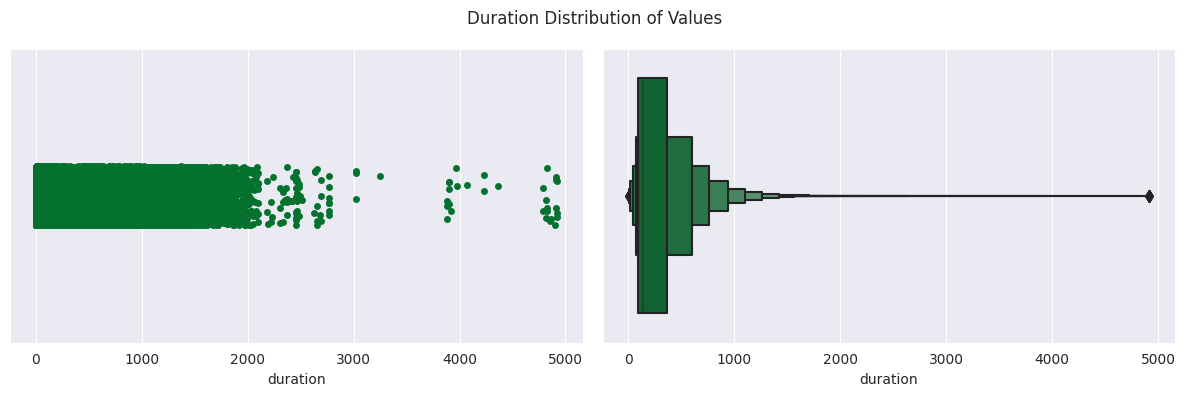

In [24]:
# We print and graph the distribution

plot_numeric(bank_train, "duration", (12, 4), "Duration Distribution of Values")

With a bit of exploration, we found that this variable represents the duration (in seconds) of the bank's last contact with the customer. This also gives us some background on the variables day and month. The range of values is from 1 second to 4917 seconds, with the lowest values representing calls likely missed, not connected, or where the customer hung up. The average call duration is around 2 minutes, while the average call duration is around 4 minutes. We found a positively skewed distribution, with a tail extending to the right, indicating high outliers. The variable does not present any erroneous or null values, although some transformation would need to be performed to handle the detected outliers.

### Campaign

Campaign variables are parameters added to URLs, primarily for tracking and attribution in marketing campaigns. They help identify the source and details of traffic generated by specific campaigns, allowing for better analysis and optimization of marketing strategies. Campaign performance tracking helps determine which marketing strategies are most effective by attributing conversions and other actions to specific campaigns. They help improve segmentation and personalization; by understanding which campaigns drive specific user behaviors, marketers can refine segmentation and personalize future campaigns. Campaign variables can be used with automated reporting tools to track campaign progress and performance.


Number of null values:  0 
Unique values:  52 
Variable range: 1 to 63 




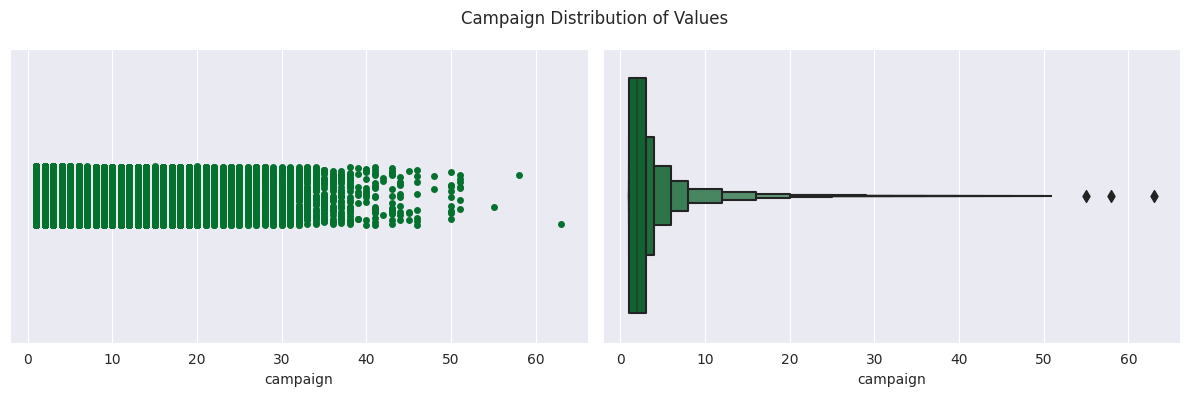

In [25]:
# We print and graph the distribution

plot_numeric(bank_train, "campaign", (12, 4), "Campaign Distribution of Values")

The variable contains 52 unique values, with a range from 1 to 63. These values represent the number of contacts made to the customer in the campaign. Analyzing the distribution, we again find a positive skewness, with a pronounced tail to the right, and the clear presence of outliers. The average number of contacts made is around 2 in the data set, with the 5th percentile at 1 and the 95th percentile at 7. A more in-depth comparison and analysis with the target variable will be interesting later. The variable does not present erroneous or null values.

### Pdays

In the context of marketing models or data analysis, the variable pdays typically represents the number of days since the last contact with a customer in a previous campaign. A value of -1 or 999 indicates that the customer was not previously contacted in previous campaigns, which allows for differentiating between previously contacted customers and those who are new to the campaign. This variable is used to assess the frequency and recency of customer contacts, which can be relevant for predicting response to new campaigns. In other words, pdays helps understand a customer's contact history in previous campaigns. Positive values indicate the number of days since the last contact. Information in pdays can be useful for analyzing the effectiveness of marketing campaigns, as the frequency and recency of contacts can influence the likelihood of a customer responding positively to a new campaign.


Number of null values:  0 
Unique values:  596 
Variable range: -1 to 871 




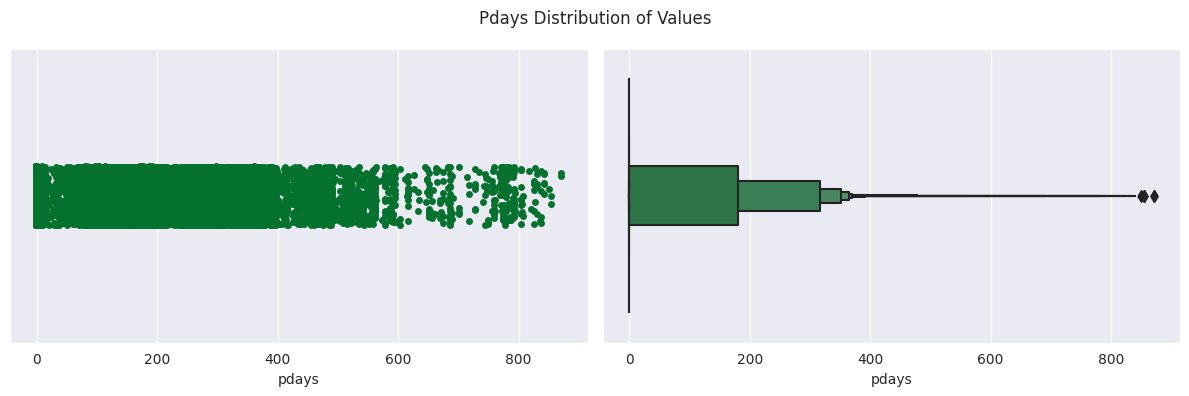

In [26]:
# We print and graph the distribution

plot_numeric(bank_train, "pdays", (12, 4), "Pdays Distribution of Values")

The variable contains 596 distinct values, ranging from -1, which, as previously mentioned, represents customers who were not previously contacted in previous campaigns, to the highest value of 871 contacts. The average number of customers was not contacted, while the average number of contacts was around 22. The variable has a positively skewed distribution, with the presence of outliers. No null or erroneous values were found. A more in-depth analysis of the variable will be required to evaluate it against the target variable.

### Previous

Previous marketing strategies can be analyzed by examining various marketing variables. These variables can be categorized into controllable factors, also known as the marketing mix (the 4 Ps: product, price, place, and promotion), and external factors that influence the market. Understanding these variables is crucial to optimizing marketing strategies and achieving business objectives. As in this case, the variable allows us to understand the customer's background regarding previous campaigns. By analyzing these variables, marketers can gain insight into past performance, identify areas for improvement, and develop more effective strategies for future campaigns.


Number of null values:  0 
Unique values:  50 
Variable range: 0 to 200 




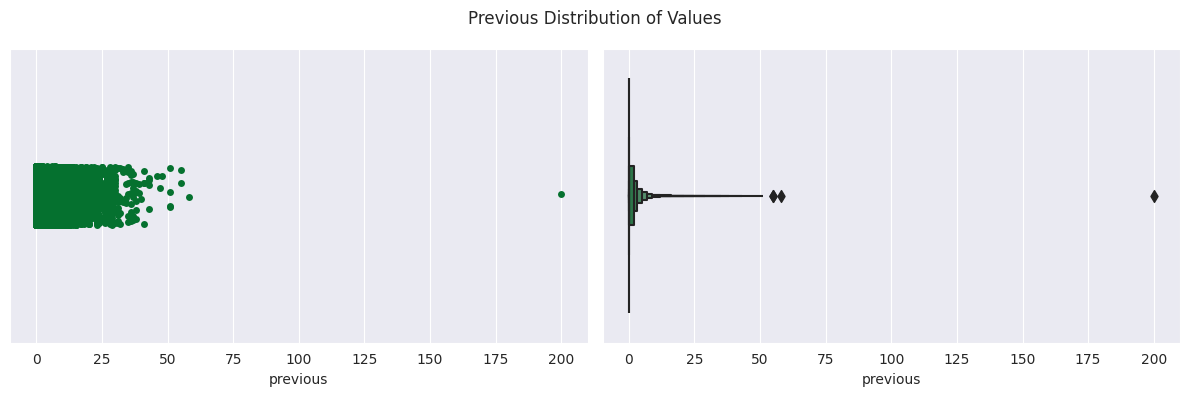

In [27]:
# We print and graph the distribution

plot_numeric(bank_train, "previous", (12, 4), "Previous Distribution of Values")

This variable represents the number of previous contacts made to a particular customer prior to the current campaign. It presents 50 distinct values with a range of 0 to 200. The average number of previous contacts recorded for this set is almost 0, so the presence of outliers is certain to be addressed, since the 5th and 95th percentiles, respectively, range from 0 to 2 previous contacts for these customers. A more in-depth analysis in conjunction with other variables would be important to perform later.

### Poutcome

In marketing, an outcome variable (or dependent variable) is the measure of the impact of marketing actions. It is the variable expected to change as a result of the strategies and tactics implemented. In essence, it is what marketing activities seek to measure and improve. They allow us to determine whether marketing campaigns are achieving the desired objectives. They help identify which strategies are working well and which need adjustment, they allow us to demonstrate the value of marketing investments to stakeholders, and they are the key metric that indicates whether marketing actions are generating the desired impact and contributing to the company's overall success.


Number of null values:  0 
Unique values:  4 
Distribution of values: 
 poutcome
unknown    672450
failure     45115
success     17691
other       14744
Name: count, dtype: int64 




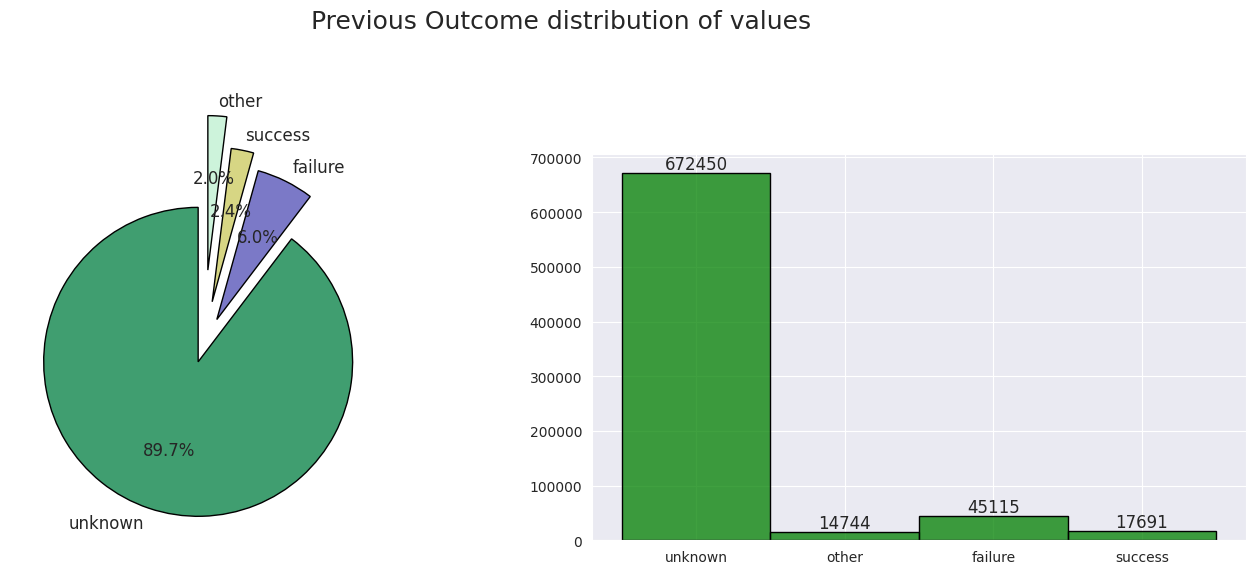

In [28]:
# We print and graph the distribution

counts_p = bank_train["poutcome"].value_counts()
labels_p = counts_p.index
sizes_p = counts_p.values
color_p = ["#409e70", "#7b79c7", "#d7d684", "#cdf3db"]
explode_p = (0.1, 0.2, 0.3, 0.5)
title_p = "Previous Outcome distribution of values"

plot_categories(bank_train["poutcome"], (14, 6), sizes_p, labels_p, color_p, explode_p, title_p)

The variable represents the result of the previous campaign, with four unique values. Analyzing the distribution, shows that most of the results are unknown. This could mean that most customers did not participate in the previous campaign or that the values are missing. The variable does not present null or erroneous values. A more comprehensive analysis, in conjunction with other variables, is required to understand these results in more depth. A mapping of this variable could be done by establishing a hierarchy for these labels.

We've completed our initial data exploration and analysis. With the information gathered, we'll move on to data wrangling, to be able to explore them in more depth asking some interesting questions to gain greater insights from the data.

# Data wrangling

We will analyze the presence of possible duplicate values, check for null values, and handle outliers, as well as perform the corresponding transformations or changes to the variables to perform a more in-depth analysis. We will make a copy of the data set for analysis and retain the original data for preprocessing to prevent data leakage later.

In [29]:
# We make a copy of the original dataset

bank_new = bank_train.copy()

In [30]:
# We confirm that there is no null values

null_values = pd.DataFrame(
        {"Null Data" : bank_new.isnull().sum(), 
         "Percentage" : (bank_new.isnull().sum()) / (len(bank_new)) * (100)})

null_values

Null Data  Percentage
age                0         0.0
job                0         0.0
marital            0         0.0
education          0         0.0
default            0         0.0
balance            0         0.0
housing            0         0.0
loan               0         0.0
contact            0         0.0
day                0         0.0
month              0         0.0
duration           0         0.0
campaign           0         0.0
pdays              0         0.0
previous           0         0.0
poutcome           0         0.0
y                  0         0.0

In [31]:
# We check for duplicate data

print(f"Length: {len(bank_new.duplicated())}")
print(f"Duplicates: {bank_new.duplicated().sum()}")

Length: 750000
Duplicates: 0


We can corroborate what we observed in the data exploration, we did not find null or erroneous values, nor the presence of duplicates. We will try to normalize some distributions, to reduce outliers for our analysis. Additionally, we'll change some variables to binary, taking into account their content and distribution, such as almost all data with a zero value or the presence of a large number of outliers. Finally, we'll create the datetime variable from the day and month columns to deepen our analysis.

In [32]:
# We set the target labels for analysis

bank_new["y"] = bank_new["y"].replace([0, 1], ["Will not subscribe", "Will subscribe"])

In [33]:
# We replace the values with categorical ones

bank_new["pdays"] = np.where(bank_new["pdays"] >= 0, "Yes", "No")
bank_new["previous"] = np.where(bank_new["previous"] > 0, "Yes", "No")

In [34]:
# We replace with an upper threshold(95%) and lower threshold(5%) approximate value

bank_new["age"] = bank_new["age"].clip(lower=18, upper=70).round(decimals=0)
bank_new["balance"] = bank_new["balance"].clip(lower=-287, upper=3400).round(decimals=0)
bank_new["duration"] = bank_new["duration"].clip(lower=1, upper=750).round(decimals=0)
bank_new["campaign"] = bank_new["campaign"].clip(lower=1, upper=6).round(decimals=0)

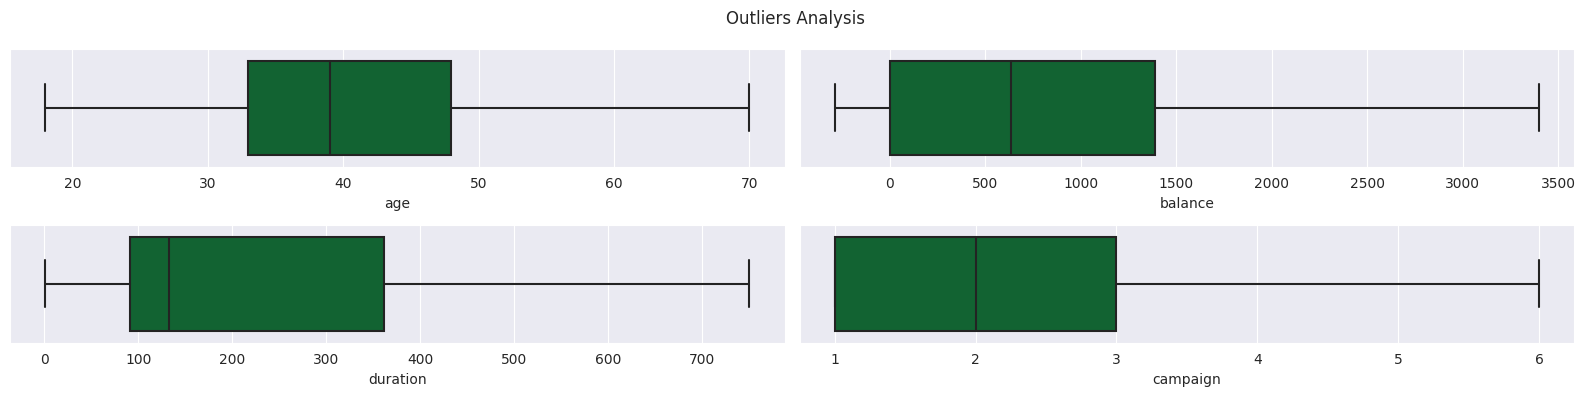

In [35]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(16, 4))

sns.boxplot(x=bank_new["age"], palette=palette, ax=axes[0,0])
sns.boxplot(x=bank_new["balance"], palette=palette, ax=axes[0,1])
sns.boxplot(x=bank_new["duration"], palette=palette, ax=axes[1,0])
sns.boxplot(x=bank_new["campaign"], palette=palette, ax=axes[1,1])

plt.suptitle(t="Outliers Analysis")
plt.tight_layout()
plt.show()

In [36]:
bank_new.describe()

age        balance            day       duration  \
count  750000.000000  750000.000000  750000.000000  750000.000000   
mean       40.889397     928.078632      16.117209     240.075575   
std         9.975196    1095.934717       8.250832     224.098513   
min        18.000000    -287.000000       1.000000       1.000000   
25%        33.000000       0.000000       9.000000      91.000000   
50%        39.000000     634.000000      17.000000     133.000000   
75%        48.000000    1390.000000      21.000000     361.000000   
max        70.000000    3400.000000      31.000000     750.000000   

            campaign  
count  750000.000000  
mean        2.299485  
std         1.534799  
min         1.000000  
25%         1.000000  
50%         2.000000  
75%         3.000000  
max         6.000000

In [37]:
bank_new.describe(exclude=np.number)

job  marital  education default housing    loan   contact  \
count       750000   750000     750000  750000  750000  750000    750000   
unique          12        3          4       2       2       2         3   
top     management  married  secondary      no     yes      no  cellular   
freq        175541   480759     401683  737151  411288  645023    486655   

         month   pdays previous poutcome                   y  
count   750000  750000   750000   750000              750000  
unique      12       2        2        4                   2  
top        may      No       No  unknown  Will not subscribe  
freq    228411  672434   672431   672450              659512

We've finished preparing the data for our questions of interest, with the goal of exploring and understanding the data in more depth. I encourage you to try different approaches or handle distributions and outliers using other methods. Next, we'll complete the data manipulation by creating the datetime column using the variables "day" and "month".

In [38]:
# We create the new column "year"

bank_new["year"] = 2024

# We map the "month" column to avoid pandas datetime errors

month_map = {
    "jan": 1, "feb": 2, "mar": 3, "apr": 4, "may": 5, "jun": 6,
    "jul": 7, "aug": 8, "sep": 9, "oct": 10, "nov": 11, "dec": 12
}

# We create a new column with the numeric values of the month

bank_new["month"] = bank_new["month"].str.lower().map(month_map)

In [39]:
# We combine the three columns into a new column "date" of type datetime

bank_new["date"] = pd.to_datetime(bank_new[["year", "month", "day"]], errors="coerce")

# We check all the values in the column

day_data = bank_new["date"].dt.day
month_data = bank_new["date"].dt.month
year_data = bank_new["date"].dt.year

print(
    "\nUnique day values: ", day_data.unique(),
    "\nUnique values of the month: ", month_data.unique(),
    "\nUnique values of year: ", year_data.unique()
)


Unique day values:  [25. 18. 14. 28.  3. 20. 21. 31.  4.  8.  5. 24. 11. 12. 26. 30.  6. 10.
 19. 17.  2. 13. 29. 23. 27.  7.  9. 16.  1. 22. 15. nan] 
Unique values of the month:  [ 8.  6.  5.  2.  4. 11.  7.  1. 10.  3.  9. 12. nan] 
Unique values of year:  [2024.   nan]


We can see that creating the "date" variable generates null values. This could be due to errors not previously detected in the exploratory analysis, such as incorrectly entered months or, more likely, days. By using the errors="coerce" parameter, we can easily identify rows with erroneous data.

In [40]:
# We separate the erroneous rows

rows_with_error = bank_new[bank_new["date"].isnull()]

# We show the problematic rows for inspection

rows_with_error

age          job   marital  education default  balance housing loan  \
id                                                                            
55107    70      retired   married    primary      no      482      no   no   
83144    36     services   married  secondary      no      447     yes   no   
86968    70      retired   married  secondary      no      482      no   no   
92576    65      retired   married  secondary      no     3400      no   no   
101180   54      retired   married  secondary      no     2959      no   no   
106167   62      retired   married    primary      no     1388      no   no   
110351   51   unemployed  divorced   tertiary      no      846      no   no   
153251   55      retired   married  secondary      no      588     yes   no   
174144   36   technician   married   tertiary      no     2374      no  yes   
190408   33   management   married   tertiary      no     3400     yes   no   
205297   25   technician    single   tertiary      no     2786      no   no   
230545   34     services    single  secondary      no     3400      no   no   
271765   44     services   married  secondary      no      755      no   no   
273231   36       admin.    single  secondary      no     2715     yes   no   
280757   33   management   married   tertiary      no      575      no   no   
324904   31      student    single  secondary      no     3055      no   no   
338275   37   unemployed   married    primary      no        0      no  yes   
338522   63      retired  divorced  secondary      no     2540      no   no   
364588   58      retired   married   tertiary      no     1227      no   no   
392150   37   management   married   tertiary      no       13     yes   no   
395755   55   technician   married   tertiary      no     2326     yes   no   
407860   39  blue-collar   married  secondary      no     1411     yes   no   
413160   70      retired   married    primary      no      619      no   no   
419638   31   management    single   tertiary      no     3400      no   no   
449116   61      retired  divorced  secondary      no     2960      no   no   
486019   37    housemaid   married    primary      no      982      no   no   
486417   37   technician   married  secondary      no      527      no   no   
546792   54   unemployed   married  secondary      no     1047      no   no   
554291   26   management   married   tertiary      no     1570     yes   no   
569810   51      retired   married    primary      no     1493      no   no   
582178   68      retired   married    primary      no     1316      no   no   
613851   67      retired  divorced    unknown      no        2      no   no   
726730   69   management   married   tertiary      no        0      no   no   
737280   33      student    single  secondary      no     1883      no   no   
742043   22      student    single    unknown      no        4      no   no   

          contact  day  month  duration  campaign pdays previous poutcome  \
id                                                                          
55107    cellular   31      4       750         2    No       No  unknown   
83144    cellular   31      4       661         3   Yes      Yes  success   
86968    cellular   31      9       750         1    No       No  unknown   
92576    cellular   30      2       750         3    No       No  unknown   
101180  telephone   31      4       164         2   Yes      Yes  failure   
106167  telephone   31      9         5         3    No       No  unknown   
110351   cellular   31      9       105         1   Yes      Yes  success   
153251    unknown   31      9       525         3   Yes      Yes    other   
174144   cellular   31      2       175         1   Yes      Yes    other   
190408   cellular   30      2       520         1   Yes      Yes    other   
205297   cellular   31      6       616         1    No       No  unknown   
230545    unknown   31      9         7         1    No       No  unknown   
271765

By filtering the rows, we can clearly see that the days entered, or possibly the month, are incorrect. We can see 31 days in months with 30 days, or numbers greater than 28 or 29 (taking leap years into account) in the month of February. Since there are only 35 samples in total with incorrect values, we will delete these rows and continue with our analysis.

In [41]:
# We delete the rows with incorrect dates

bank_new.dropna(subset=["date"], inplace=True)

In [42]:
# We changed the format for more efficient memory usage

bank_new[bank_new.select_dtypes(["object"]).columns] = (
    bank_new.select_dtypes(["object"]).apply(
        lambda x: x.astype("category"))
)

In [43]:
bank_new.info()

<class 'pandas.core.frame.DataFrame'>
Index: 749965 entries, 0 to 749999
Data columns (total 19 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   age        749965 non-null  int64         
 1   job        749965 non-null  category      
 2   marital    749965 non-null  category      
 3   education  749965 non-null  category      
 4   default    749965 non-null  category      
 5   balance    749965 non-null  int64         
 6   housing    749965 non-null  category      
 7   loan       749965 non-null  category      
 8   contact    749965 non-null  category      
 9   day        749965 non-null  int64         
 10  month      749965 non-null  int64         
 11  duration   749965 non-null  int64         
 12  campaign   749965 non-null  int64         
 13  pdays      749965 non-null  category      
 14  previous   749965 non-null  category      
 15  poutcome   749965 non-null  category      
 16  y          749965 non-nul

We finished handling the data, we will proceed to ask our questions of interest, to understand the data in more depth.